In [2]:
import argparse
import json
import os

from catalyst import dl
from catalyst.dl import utils
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold
import torch
from torch import nn
from torch.utils.data import DataLoader

# from torchcontrib.optim import SWA

from constants import FilePaths, TGT_COLS
from datasets import RNAAugDatav2
from modellib import RNNmodels
from nn_trainer import get_predictions, validation_metrics

In [3]:
NUM_WORKERS = 8
BATCH_SIZE = 96
FP = FilePaths("data")
test = pd.read_json(FP.test_json, lines=True)
public_test = test.loc[test.seq_length == 107]
private_test = test.loc[test.seq_length == 130]

In [9]:
mk_sub = pd.read_csv("data/submission_filter__cnnlstm__posembv5.csv")
mk_sub2 = pd.read_csv("data/submission_filter__cnnlstm__posembv3.csv")
mk_sub3 = pd.read_csv("data/submission_filter__cnnlstm__combinedconv6.csv")
mk_sub4 = pd.read_csv("data/submission_filter__cnnlstm__mcmsre.csv")
mk_sub5 = pd.read_csv("data/submission_gcn_draftv2.csv")
mk_sub6 = pd.read_csv("data/submission_gcn__transformer__hypernode__nobackedge.csv")
mk_sub7 = pd.read_csv("data/submission_gcn__transformer__hypernode__v2.csv")

In [5]:
mk_sub5.head()

,id_seqpos,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C
0,id_00073f8be_0,0.665048,0.667753,0,0.564560,0
1,id_00073f8be_1,2.395651,3.417017,0,3.297220,0
2,id_00073f8be_2,1.692726,0.727701,0,0.848402,0
3,id_00073f8be_3,1.339310,1.170051,0,1.674303,0
4,id_00073f8be_4,0.846256,0.605372,0,0.833034,0


In [6]:
pub_sub11 = pd.read_csv("data/submission_sahil_nikhil_lightgbm_241.csv")
pub_sub12 = pd.read_csv("data/GRU_CNN_v13_ensemble (1).csv")
pub_sub1 = pub_sub12.copy()
for col in ["reactivity", "deg_Mg_pH10", "deg_Mg_50C"]:
    pub_sub1[col] = pub_sub11[col] * 0.0 + pub_sub12[col] * 1.0

pub_sub2 = pd.read_csv("data/submission_public_247.csv")
pub_sub3 = pd.read_csv("data/transformer_v2_sub (2).csv")
pub_sub4 = pd.read_csv("data/submission_deepergcn.csv")

In [10]:
pub_sub1 = pub_sub1.sort_values(by="id_seqpos").reset_index(drop=True)
pub_sub2 = pub_sub2.sort_values(by="id_seqpos").reset_index(drop=True)
pub_sub3 = pub_sub3.sort_values(by="id_seqpos").reset_index(drop=True)
pub_sub4 = pub_sub4.sort_values(by="id_seqpos").reset_index(drop=True)
mk_sub = mk_sub.sort_values(by="id_seqpos").reset_index(drop=True)
mk_sub2 = mk_sub2.sort_values(by="id_seqpos").reset_index(drop=True)
mk_sub3 = mk_sub3.sort_values(by="id_seqpos").reset_index(drop=True)
mk_sub4 = mk_sub4.sort_values(by="id_seqpos").reset_index(drop=True)
mk_sub5 = mk_sub5.sort_values(by="id_seqpos").reset_index(drop=True)
mk_sub6 = mk_sub6.sort_values(by="id_seqpos").reset_index(drop=True)
mk_sub7 = mk_sub7.sort_values(by="id_seqpos").reset_index(drop=True)


In [14]:
from scipy.stats import spearmanr
cond = np.array(pub_sub1.id_seqpos.str.split("_").str.get(2)).astype(int)
cond = cond < 81
print(spearmanr(mk_sub6.loc[cond].reactivity.values, mk_sub5.loc[cond].reactivity.values))
print(spearmanr(mk_sub7.loc[cond].reactivity.values, mk_sub5.loc[cond].reactivity.values))
print(spearmanr(mk_sub7.loc[cond].reactivity.values, mk_sub6.loc[cond].reactivity.values))

SpearmanrResult(correlation=0.9811658284721952, pvalue=0.0)
SpearmanrResult(correlation=0.9786554315469431, pvalue=0.0)
SpearmanrResult(correlation=0.9826858612077535, pvalue=0.0)


In [16]:
mk_gcn = mk_sub5.copy()
for col in ["reactivity", "deg_Mg_pH10", "deg_Mg_50C"]:
    mk_gcn[col] = np.mean([mk_sub5[col], mk_sub6[col], mk_sub7[col]], 0)
mk_gcn.to_csv("data/submission_mk_gcn_v2_3runs.csv", index=False)
print(spearmanr(mk_gcn.loc[cond].reactivity.values, mk_sub6.loc[cond].reactivity.values))
mk_gcn.head()


SpearmanrResult(correlation=0.9946113461174219, pvalue=0.0)


,id_seqpos,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C
0,id_00073f8be_0,0.664420,0.645763,0,0.549395,0
1,id_00073f8be_1,2.271343,3.208678,0,3.180809,0
2,id_00073f8be_10,0.272651,0.449055,0,0.288794,0
3,id_00073f8be_100,0.303941,0.492861,0,0.580561,0
4,id_00073f8be_101,0.534761,0.301490,0,0.354480,0


In [ ]:
mksub_gcn = np.mean([mk_sub5, mk_sub6])

In [77]:
mk_sub.id_seqpos.iloc[0].split("_")[:2]

['id', '00073f8be']

In [78]:
mk_subv1v2 = mk_sub2.copy()
for col in ["reactivity", "deg_Mg_pH10", "deg_Mg_50C"]:
    mk_subv1v2[col] = mk_sub[col] * 0.25 + mk_sub2[col] * 0.25 + mk_sub3[col] * 0.25 + mk_sub4[col] * 0.25
    
mk_subv1v2.to_csv("data/submission_mk_blend_2032cv.csv", index=False)
mk_subv1v2.head()

,id_seqpos,reactivity,deg_Mg_pH10,deg_Mg_50C,deg_pH10,deg_50C
0,id_00073f8be_0,0.688990,0.618457,0.528022,-0.034667,0.004661
1,id_00073f8be_1,2.216449,2.940250,3.083908,-0.030310,0.058409
2,id_00073f8be_10,0.467700,0.557841,0.528128,-0.024280,0.041675
3,id_00073f8be_100,0.267033,0.380665,0.471629,-0.036803,0.040534
4,id_00073f8be_101,0.449756,0.223306,0.279474,-0.036154,0.046067


In [79]:
private_ids = set(private_test.id.tolist())
mk_sub["is_private"] = mk_sub.id_seqpos.apply(lambda x: "_".join(x.split("_")[:2]) in private_ids)

In [80]:
cond = np.array(pub_sub1.id_seqpos.str.split("_").str.get(2)).astype(int)
cond = cond < 68

In [81]:
from scipy.stats import spearmanr
spearmanr(pub_sub1.loc[cond].reactivity.values, mk_subv1v2.loc[cond].reactivity.values)

SpearmanrResult(correlation=0.9752967498455463, pvalue=0.0)

In [82]:
spearmanr(pub_sub1.loc[cond].reactivity.values, mk_sub5.loc[cond].reactivity.values)

SpearmanrResult(correlation=0.9624134553247614, pvalue=0.0)

In [83]:
spearmanr(pub_sub3.loc[cond].reactivity, pub_sub1.loc[cond].reactivity)

SpearmanrResult(correlation=0.9709288523827808, pvalue=0.0)

In [84]:
spearmanr(pub_sub3.loc[cond].reactivity, mk_subv1v2.loc[cond].reactivity)

SpearmanrResult(correlation=0.9620641726498925, pvalue=0.0)

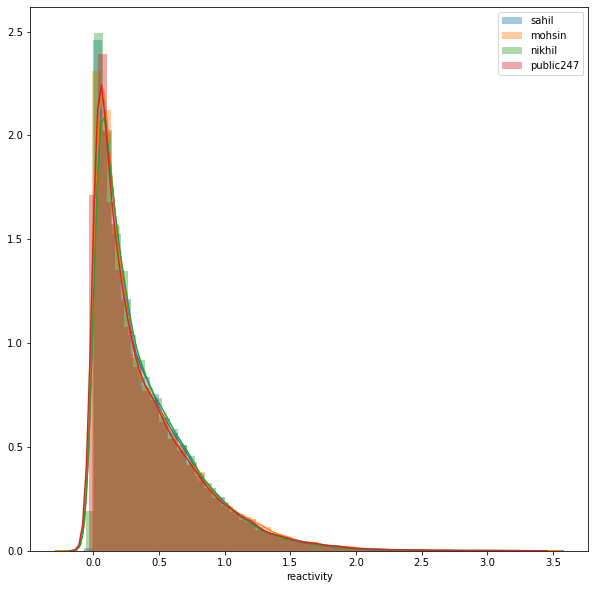

In [85]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
sns.distplot(pub_sub1.loc[(mk_sub.is_private == 0) & cond, "reactivity"])
sns.distplot(mk_sub5.loc[(mk_sub.is_private == 0) & cond, "reactivity"])
sns.distplot(pub_sub3.loc[(mk_sub.is_private == 0) & cond, "reactivity"])
sns.distplot(pub_sub2.loc[(mk_sub.is_private == 0) & cond, "reactivity"])

plt.legend(["sahil", "mohsin", "nikhil", "public247"])

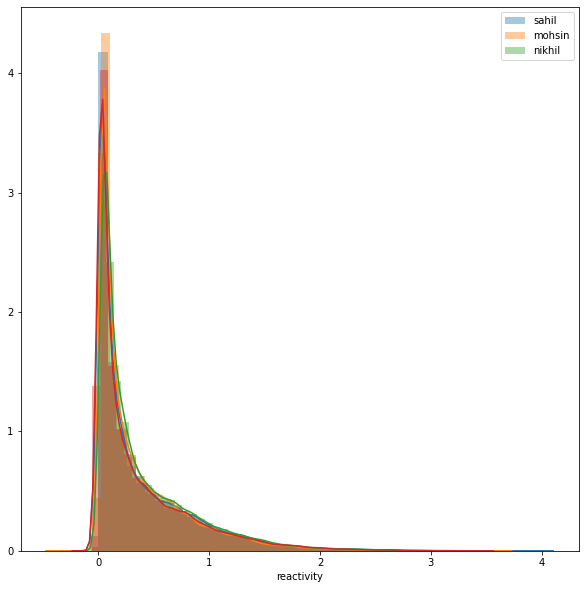

In [86]:
plt.figure(figsize=(10, 10))
sns.distplot(pub_sub1.loc[(mk_sub.is_private == 1) & cond, "reactivity"])
sns.distplot(mk_sub5.loc[(mk_sub.is_private == 1) & cond, "reactivity"])
sns.distplot(pub_sub3.loc[(mk_sub.is_private == 1) & cond, "reactivity"])
sns.distplot(pub_sub2.loc[(mk_sub.is_private == 1) & cond, "reactivity"])
plt.legend(["sahil", "mohsin", "nikhil"])

#submission = submission.sort_values(by="id_seqpos").reset_index(drop=True)

In [87]:
spearmanr(pub_sub1.reactivity, pub_sub2.reactivity)

SpearmanrResult(correlation=0.8456848716744891, pvalue=0.0)

In [66]:
spearmanr(pub_sub1.reactivity, pub_sub3.reactivity)

SpearmanrResult(correlation=0.002266042507045991, pvalue=0.1251578374019933)

In [67]:
spearmanr(pub_sub1.reactivity, pub_sub4.reactivity)

SpearmanrResult(correlation=-0.000481045886338678, pvalue=0.7447772695439483)

In [68]:
spearmanr(pub_sub2.reactivity, pub_sub4.reactivity)

SpearmanrResult(correlation=0.952907447196674, pvalue=0.0)

In [69]:
sum(mk_subv1v2["reactivity"] < 0.0)

428

In [88]:
submission = pub_sub1.copy()
for col in ["reactivity", "deg_Mg_pH10", "deg_Mg_50C"]:
     submission[col] = 0.3*pub_sub1[col] + 0.2*pub_sub3[col] + 0.3*mk_subv1v2[col] + 0.2*mk_sub5[col]
submission.head()

,reactivity,deg_Mg_pH10,deg_Mg_50C,deg_50C,deg_pH10,id_seqpos
0,0.683339,0.616022,0.529215,0.0,0.0,id_00073f8be_0
1,2.158210,3.018706,3.061719,0.0,0.0,id_00073f8be_1
2,0.349259,0.511643,0.418451,0.0,0.0,id_00073f8be_10
3,0.434994,0.572055,0.648264,0.0,0.0,id_00073f8be_100
4,0.635908,0.376267,0.459185,0.0,0.0,id_00073f8be_101


In [89]:
submission.to_csv('data/submission_30svv13_30mkv3_20svtfm_20mkgcn.csv', index=False)

In [31]:
submission = pub_sub1.copy()
for col in ["reactivity", "deg_Mg_pH10", "deg_Mg_50C"]:
     submission[col] = 0.25*pub_sub1[col] + 0.25*pub_sub2[col] + 0.3*mk_subv1v2[col] + 0.1*pub_sub3[col] + 0.1*pub_sub4[col]
submission.head()

,reactivity,deg_Mg_pH10,deg_Mg_50C,id_seqpos,deg_50C,deg_pH10
0,0.751547,0.623109,0.534492,id_00073f8be_0,0,0
1,2.262539,3.046963,3.046512,id_00073f8be_1,0,0
2,0.356475,0.522828,0.440698,id_00073f8be_10,0,0
3,0.157809,0.181375,0.234997,id_00073f8be_100,0,0
4,0.361655,0.063647,0.109497,id_00073f8be_101,0,0


In [33]:
submission.to_csv('data/submission_25sv_30mk_25pub_10nnm_10gcn.csv', index=False)

In [48]:
for col in ["reactivity", "deg_Mg_pH10", "deg_Mg_50C"]:
     submission[col] = 0.3*pub_sub1[col] + 0.2*pub_sub2[col] + 0.3*mk_subv1v2[col] + 0.05*pub_sub3[col] + 0.05*pub_sub4[col]
submission.head()

,reactivity,deg_Mg_pH10,deg_Mg_50C,id_seqpos,deg_50C,deg_pH10
0,0.768850,0.620635,0.538276,id_00073f8be_0,0,0
1,2.329552,3.113950,3.088774,id_00073f8be_1,0,0
2,0.354250,0.530385,0.439045,id_00073f8be_10,0,0
3,0.166879,0.188463,0.240570,id_00073f8be_100,0,0
4,0.387305,0.068990,0.108982,id_00073f8be_101,0,0


In [49]:
submission.to_csv('data/submission_30sv1113_30mk_30pub_5nm_5gcn.csv', index=False)

In [50]:
for col in ["reactivity", "deg_Mg_pH10", "deg_Mg_50C"]:
     submission[col] = 0.4*pub_sub1[col] + 0.2*pub_sub2[col] + 0.4*mk_subv1v2[col] + 0.0*pub_sub3[col] + 0.0*pub_sub4[col]
submission.head()

,reactivity,deg_Mg_pH10,deg_Mg_50C,id_seqpos,deg_50C,deg_pH10
0,0.759482,0.609955,0.535987,id_00073f8be_0,0,0
1,2.332129,3.086480,3.073632,id_00073f8be_1,0,0
2,0.382573,0.547632,0.474250,id_00073f8be_10,0,0
3,0.107729,0.106234,0.121008,id_00073f8be_100,0,0
4,0.322918,0.017842,0.040296,id_00073f8be_101,0,0


In [2]:
submission["reactivity"] < 0.5

NameError: name 'submission' is not defined

In [1]:
sns.distplot(submission["reactivity"])

NameError: name 'sns' is not defined

In [51]:
submission.to_csv('data/submission_40sv1113_40mkv3v4_20pub.csv', index=False)

In [29]:
df = pd.read_pickle("data/augmentation_data.pkl")

In [40]:
submission.join(df.groupby("id")["feat"].apply(list), on="id_se")

AttributeError: 'Series' object has no attribute 'join'

In [31]:
df.feat.iloc[100]

'f0 f0 f0 f0 f0 f0 s0 s0 s0 i0 i0 i0 s1 s1 s1 s1 s2 s2 s2 s2 s2 i1 i1 i1 s3 s3 s3 s3 i2 i2 s4 s4 s4 s4 s4 h0 h0 h0 h0 h0 s4 s4 s4 s4 s4 s3 s3 s3 s3 s2 s2 s2 s2 s2 i3 i3 i3 s1 s1 s1 s1 s0 s0 s0 m0 m0 m0 m0 s5 s5 s5 s5 s5 s5 s5 h1 h1 h1 h1 s5 s5 s5 s5 s5 s5 s5 t0 t0 t0 t0 t0 t0 t0 t0 t0 t0 t0 t0 t0 t0 t0 t0 t0 t0 t0 t0 t0'

In [33]:
import itertools

all_loops = df.feat.str.split(' ').tolist()

In [41]:
def match_pair(structure):
    pair = [-1] * len(structure)
    pair_no = -1

    pair_no_stack = []
    for i, c in enumerate(structure):
        if c == '(':
            pair_no += 1
            pair[i] = pair_no
            pair_no_stack.append(pair_no)
        elif c == ')':
            pair[i] = pair_no_stack.pop()
    return pair

In [44]:
match_pair(df.structure.iloc[888])

[-1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 -1,
 -1,
 -1,
 -1,
 6,
 5,
 4,
 3,
 2,
 1,
 0,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1]

In [3]:
import pandas as pd
train = pd.read_json("data/train.json", lines=True)
sequence = train.sequence.iloc[0]
structure = train.structure.iloc[0]

In [20]:
def predict_loop(sequence, structure):
    !echo $sequence > a.dbn
    !echo "$structure" >> a.dbn
    !perl bpRNA/bpRNA.pl a.dbn
    with open("a.st") as stf:
        result = [l.strip('\n') for l in stf]
    pl = result[5]
    segments = [row  for row in result if row.startswith('segment')]
    num_seg, num_bp = len(segments), sum([int(seg.split(" ")[1].strip("bp")) for seg in segments])    
    return pl, num_seg, num_bp

In [22]:
%%time
outputs = predict_loop(sequence, structure)

CPU times: user 26.4 ms, sys: 16.2 ms, total: 42.6 ms
Wall time: 1.03 s


In [26]:
df = pd.read_pickle("data/augmentation_data.pkl")
df.shape

(9600, 12)

In [27]:
df.head()

,id,structure,match,sim_type,log_gamma,sequence,seq_length,seq_scored,reactivity,deg_Mg_pH10,deg_Mg_50C,feat
0,id_001f94081,.....((((((.......)))).)).((.....((..((((((......,0.656513,vienna_2,1,GGAAAAGCUCUAAUAACAGGAGACUAGGACUACGUAUUUCUAGGUA...,107,68,"[0.3297, 1.5693000000000001, 1.1227, 0.8686, 0...","[0.7556, 2.983, 0.2526, 1.3789, 0.637600000000...","[0.35810000000000003, 2.9683, 0.2589, 1.4552, ...",f0 f0 f0 f0 f0 s0 s0 s1 s1 s1 s1 h0 h0 h0 h0 h...
1,id_001f94081,((...((((((..(...))))).)).(((.(..(((.((((((......,0.579058,vienna_2,3,GGAAAAGCUCUAAUAACAGGAGACUAGGACUACGUAUUUCUAGGUA...,107,68,"[0.3297, 1.5693000000000001, 1.1227, 0.8686, 0...","[0.7556, 2.983, 0.2526, 1.3789, 0.637600000000...","[0.35810000000000003, 2.9683, 0.2589, 1.4552, ...",f0 f0 f0 f0 f0 s0 s0 s1 s1 s1 s1 h0 h0 h0 h0 h...
2,id_001f94081,.....((((((.......)))).)).((.....((..((((((......,0.856787,nupack,1,GGAAAAGCUCUAAUAACAGGAGACUAGGACUACGUAUUUCUAGGUA...,107,68,"[0.3297, 1.5693000000000001, 1.1227, 0.8686, 0...","[0.7556, 2.983, 0.2526, 1.3789, 0.637600000000...","[0.35810000000000003, 2.9683, 0.2589, 1.4552, ...",f0 f0 f0 f0 f0 s0 s0 s1 s1 s1 s1 h0 h0 h0 h0 h...
3,id_001f94081,.....((((((..(...))))).)).((..((.(((.((((((......,0.784306,nupack,3,GGAAAAGCUCUAAUAACAGGAGACUAGGACUACGUAUUUCUAGGUA...,107,68,"[0.3297, 1.5693000000000001, 1.1227, 0.8686, 0...","[0.7556, 2.983, 0.2526, 1.3789, 0.637600000000...","[0.35810000000000003, 2.9683, 0.2589, 1.4552, ...",f0 f0 f0 f0 f0 s0 s0 s1 s1 s1 s1 h0 h0 h0 h0 h...
4,id_0049f53ba,.....(((((((((((((((((((((((....)))))))))).)))...,0.928543,vienna_2,1,GGAAAAAGCGCGCGCGGUUAGCGCGCGCUUUUGCGCGCGCUGUACC...,107,68,"[0.0, 0.0, 0.0, 2.2965, 0.0, 0.0, 0.0, 0.0, 0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[4.8511, 4.0426, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",f0 f0 f0 f0 f0 s0 s0 s0 s0 s0 s0 s0 s0 s0 s0 s...


In [66]:
a = torch.tensor([1, 2, 3, 4]).type(torch.float32)
a.std()

tensor(1.2910)

In [ ]:
np.load("data/")